# Autoencoder



In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

### Load Data

We will use the Rat EEG data

Since this is an unsupervised method we will not need to use the labels (y values)

In [2]:
path = '/Users/kuba/Documents/data/Raw/pt_ekyn_500hz/000_0.pt'

In [3]:
X, y = torch.load(path)

In [4]:
X_train, X_dev =  X[:7000], X[7000:]

X_train.shape, X_dev.shape

(torch.Size([7000, 5000]), torch.Size([1640, 5000]))

### MODEL DEF
We make a simple Autoencoder

In [5]:
class MODEL00(nn.Module):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoderl0 = nn.Linear(5000, 2048)
        self.encoderl1 = nn.Linear(2048, 1024)
        self.encoderl2 = nn.Linear(1024, 512)

        self.decoderl0 = nn.Linear(512, 1024)
        self.decoderl1 = nn.Linear(1024, 2048)
        self.decoderl2 = nn.Linear(2048, 5000)
        

    def forward(self, x):
        x = self.encoderl0(x) 
        x = self.encoderl1(x)
        code = self.encoderl2(x)

        x = self.decoderl0(code)
        x = self.decoderl1(x)
        x = self.decoderl2(x)
        return x
    
    def decode(self, code):
        x = self.decoderl0(code)
        x = self.decoderl1(x)
        x = self.decoderl2(x)
        return x
    
    def encode(self, x):
        x = self.encoderl0(x) 
        x = self.encoderl1(x)
        code = self.encoderl2(x)
        return code

In [6]:
model00 = MODEL00()

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model00.parameters(), lr=0.001)

In [8]:
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=1024)


In [9]:
device = 'mps'

model00 = model00.to(device)
dev_dataset = X_dev.to(device)

In [10]:
lossi = []
lossidev = []

In [ ]:
for epoch in tqdm(range(100)):
    #train step
    loss_total = 0
    model00.train()
    for train_batch, *_ in train_loader:
        train_batch = train_batch.to(device)

        logits = model00(train_batch)
        loss = criterion(logits, train_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item() 
    
    lossi.append(loss_total / len(train_batch))

    
    #dev step
    model00.eval()
    with torch.no_grad():
        devlogits = model00(dev_dataset)
        devloss = criterion(devlogits, dev_dataset)
        lossidev.append(devloss.item())

100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


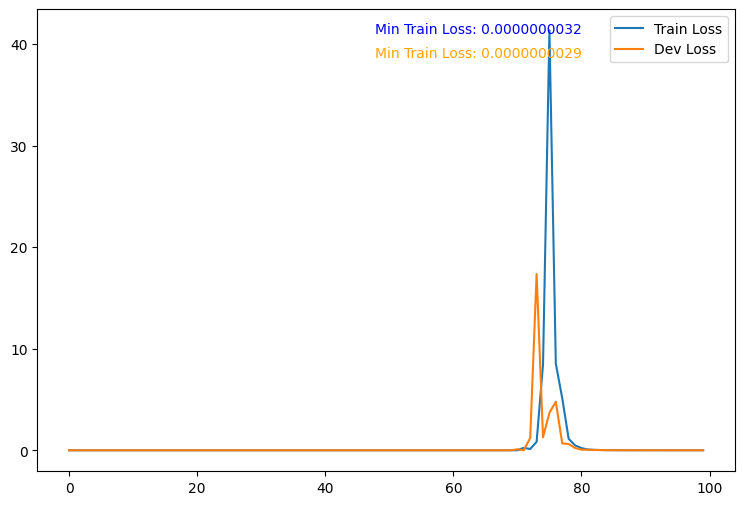

In [12]:
min_trl = min(lossi)
plt.figure(figsize=(9,6))
plt.plot(lossi, label="Train Loss")
plt.plot(lossidev, label="Dev Loss")
plt.figtext(.5,.84,s=f'Min Train Loss: {min(lossi):.10f}',color='blue')
plt.figtext(.5,.80,s=f'Min Train Loss: {min(lossidev):.10f}',color='orange')
plt.legend()
plt.show()

Lets look at the latent space opf this code

In [13]:
model00.eval()
with torch.no_grad():
    latent_space = model00.encode(X.to(device))

now that we have the latent space lets TSNE it and vizualize it

In [14]:
latent_space = latent_space.cpu()
tsne = TSNE()

c_tsne = tsne.fit_transform(latent_space)

<Axes: xlabel='0', ylabel='1'>

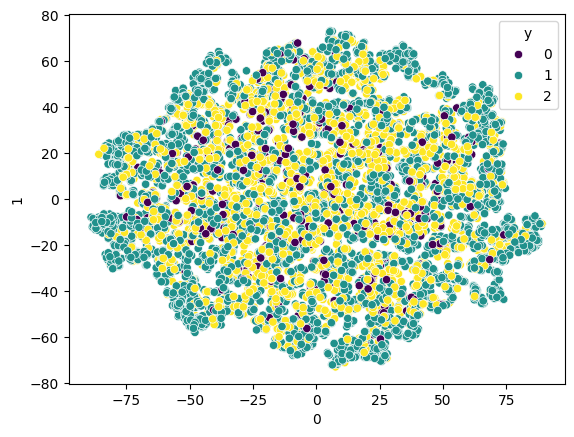

In [ ]:
df_tse = pd.DataFrame(c_tsne)
df_tse['y'] = torch.argmax(y, dim=1)
sns.scatterplot(data=df_tse, x=0, y=1, hue='y', palette='viridis')

lets look for another rat

In [19]:
path = '/Users/kuba/Documents/data/Raw/pt_ekyn_500hz/011_0.pt'
X11, y11 = torch.load(path)

In [21]:
model00.eval()
with torch.no_grad():
    pred = model00(X11.to(device))

    loss11 =  criterion(pred, X11.to(device))

print(f"Loss for Rat 011  is:{loss11.item():.10f}")

Loss for Rat 011  is:0.0019682872


In [22]:
model00.eval()
with torch.no_grad():
    latent_space11 = model00.encode(X11.to(device))

latent_space11 = latent_space11.cpu()
tsne11 = TSNE()

c_tsne11 = tsne11.fit_transform(latent_space11)

<Axes: xlabel='0', ylabel='1'>

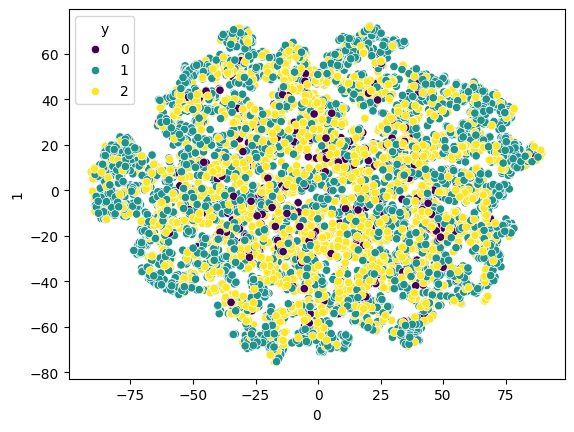

In [23]:
df_tse11 = pd.DataFrame(c_tsne11)
df_tse11['y'] = torch.argmax(y11, dim=1)
sns.scatterplot(data=df_tse11, x=0, y=1, hue='y', palette='viridis')